In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_dataset.csv to test_dataset (1).csv
Saving train_dataset.csv to train_dataset (1).csv


In [ ]:
# 1_load_inspect_svm.py
import pandas as pd

train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())


has_test_labels = "smoking" in test_df.columns
print("Test has 'smoking' column?:", has_test_labels)

print("Train smoking value counts:")
print(train_df["smoking"].value_counts(dropna=False))


Train shape: (38984, 23)
Test shape: (16708, 22)
Train columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']
Test columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
Test has 'smoking' column?: False
Train smoking value counts:
smoking
0    24666
1    14318
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv("train_dataset.csv")

X = train.drop(columns=["smoking"])
y = train["smoking"]


In [ ]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

categorical_cols = [col for col in X.columns
                    if X[col].nunique() <= 10 and col not in numeric_cols]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
Categorical: []


In [ ]:
def cap_outliers(df, cols):
    df = df.copy()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[col] = df[col].clip(lower, upper)
    return df


In [ ]:
X_capped = X.copy()
X_capped[numeric_cols] = cap_outliers(X, numeric_cols)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_capped, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [ ]:
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", SVC(kernel="rbf", probability=True))
])


In [ ]:
svm_pipe.fit(X_train_raw, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'eyesight(left)',
                                                   'eyesight(right)',
                                                   'hearing(left)',
                                                   'hearing(right)', 'systolic',
                                                   'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'Urine protein',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp',
                                                   'dental caries']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model', SVC(probability=True))])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = svm_pipe.predict(X_test_raw)
y_prob = svm_pipe.predict_proba(X_test_raw)[:,1]

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("SVM F1 Score:", f1_score(y_test, y_pred))
print("SVM AUC:", roc_auc_score(y_test, y_prob))


SVM Accuracy: 0.7523406438373733
SVM F1 Score: 0.6632955536181343
SVM AUC: 0.8273111439093914


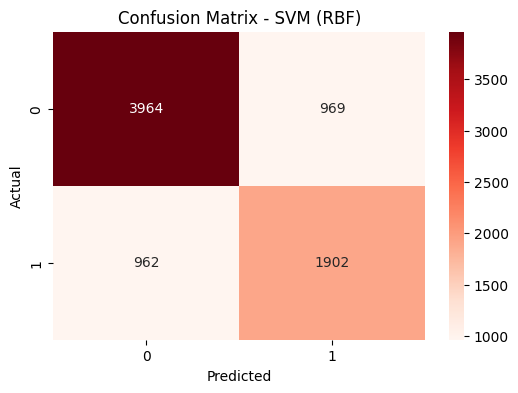

[[3964  969]
 [ 962 1902]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (RBF)")
plt.show()

print(cm)
